<a href="https://colab.research.google.com/github/stalin99835/DUDL/blob/main/gaussian_blur_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COURSE: A deep understanding of deep learning
## SECTION: Understand and design CNNs
### LECTURE: CNN to classify MNIST digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [ ]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [ ]:
nPerClass = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

widths = [1.8,2.4]

images = torch.zeros(2 * nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  ro = 2 * np.random.randn(2)
  G = np.exp( -( (X - ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2))

  G = G + np.random.randn(imgSize,imgSize)/5

  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

print(images.shape)
print(labels.shape)





torch.Size([2000, 1, 91, 91])
torch.Size([2000, 1])


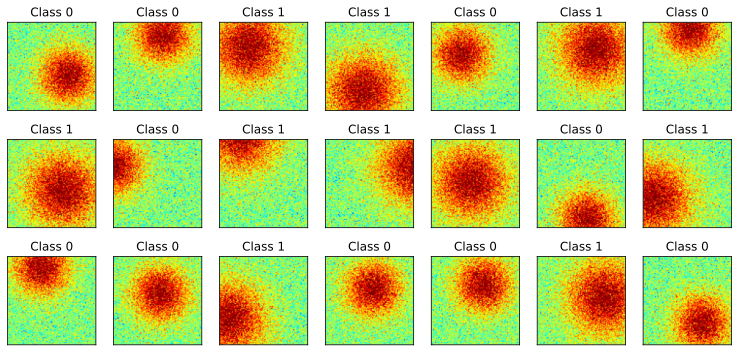

In [ ]:
fig,axs = plt.subplots(3,7,figsize=(13,6))

#print(axs)

for i,ax in enumerate(axs.flatten()):
  whichPic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichPic,:,:])
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s' %(int(labels[whichPic].item())))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()



In [ ]:
images.shape

torch.Size([2000, 1, 91, 91])

# Create train/test groups using DataLoader

In [ ]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# check size (should be images X channels X width X height)
print(train_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[0].shape)

print(train_loader.dataset.tensors[1].shape)
print(test_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([200, 1, 91, 91])
torch.Size([1800, 1])
torch.Size([200, 1])


In [ ]:
for i in range(train_loader.dataset.tensors[0].shape[0]):

  img = train_loader.dataset.tensors[0][i,:,:]

  randroll = np.random.randint(-10,11)
  img = torch.roll(img,randroll, dims=1)

  train_loader.dataset.tensors[0][i,:,:] = img

for i in range(test_loader.dataset.tensors[0].shape[0]):

  img = test_loader.dataset.tensors[0][i,:,:]

  randroll = np.random.randint(-10,11)
  img = torch.roll(img,randroll, dims=1)

  test_loader.dataset.tensors[0][i,:,:] = img

In [ ]:
def createNet():
  class gaussNet (nn.Module):
    def __init__(self):
      super().__init__()

      self.enc = nn.Sequential(
        nn.Conv2d(1,6,3,padding=1),  #outputsize (91+2*1-3)/1 + 1 = 91
        nn.ReLU(),                   #relu = layer
        nn.AvgPool2d(2,2),           #output size  = 91/2 = 45
        nn.Conv2d(6,4,3,padding=1),  #output size (45+2*1-3)/1 + 1 =45
        nn.ReLU(),
        nn.AvgPool2d(2,2),           #output size = 45/2 = 22
        nn.Flatten(),
        nn.Linear(22*22*4,50),
        nn.Linear(50,1),
      )
    def forward(self,x):
      return self.enc(x)

  net = gaussNet()

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return(net,lossfun,optimizer)





In [ ]:
net, lossfun, optimizer = createNet()

X,y = next(iter(train_loader))
yHat = net(X)

#print(y)

print('yHat and y shapes')
print(yHat.shape)
print(y.shape)

loss = lossfun(yHat,y)
print(' ')
print('Loss')
print(loss)

summary(net,(1,imgSize,imgSize))



yHat and y shapes
torch.Size([32, 1])
torch.Size([32, 1])
 
Loss
tensor(0.7030, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/b

In [ ]:
def modelTrainer():
  numepochs = 10

  net, lossfun, optimizer = createNet()

  trainLoss = torch.zeros(numepochs)
  testLoss = torch.zeros(numepochs)
  trainAcc = torch.zeros(numepochs)
  testAcc = torch.zeros(numepochs)

  for epochi in range(numepochs):
    batchLoss = []
    batchAcc = []

    for X,y in train_loader:
      yHat = net(X)
      loss = lossfun(yHat,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>.5)==y).float()).item())
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = 100*np.mean(batchAcc)

    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)
    testLoss[epochi] = loss.item()
    testAcc[epochi] = 100*torch.mean(( (yHat>.5)==y).float()).item()
  return trainLoss, testLoss, trainAcc, testAcc,net

In [ ]:
trainLoss,testLoss,trainAcc,testAcc,net = modelTrainer()


Text(0.5, 1.0, 'Final model test accuracy: 99.00%')

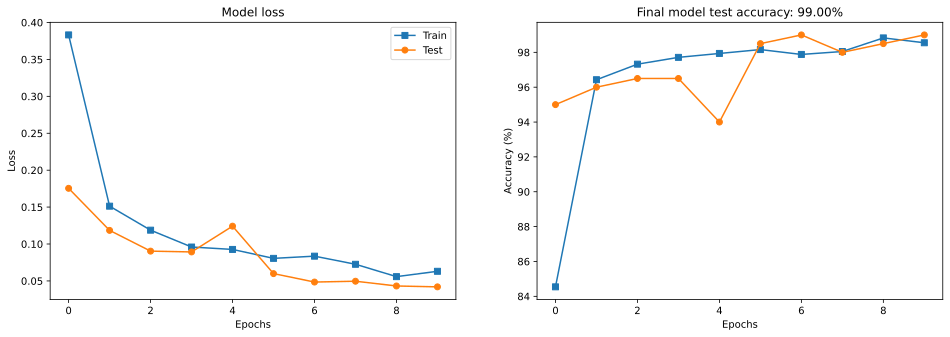

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')





# Create the DL model

In [ ]:
# create a class for the model
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle
      super().__init__()

      #conv and pooling parms
      #start image size
      image_side1 = 28
      image_side2 = 28

      #layer 1
      in_channels1 = 1
      out_channels1 = 10
      kernel_s= 5
      stride_s = 1
      padding_s = 1
      pool_s = 2

      #layer2
      out_channels2 = 20


      ### convolution layers
      # layer 1, define and calculate output image size
      self.conv1 = nn.Conv2d( in_channels1,out_channels1,kernel_size=kernel_s,stride=stride_s,padding=padding_s)
      im_calc_size1a = int(np.floor(((image_side1+2*padding_s-kernel_s)/stride_s + 1)/pool_s))
      im_calc_size1b = int(np.floor(((image_side2+2*padding_s-kernel_s)/stride_s + 1)/pool_s))
      print(f'calc size conv1a out {im_calc_size1a}') if self.print else None
      print(f'calc size conv1b out {im_calc_size1b}') if self.print else None

      #layer 2, define and calculate image size
      self.conv2 = nn.Conv2d(out_channels1,out_channels2,kernel_size=5,stride=1,padding=1)
      im_calc_size2a = int(np.floor(((im_calc_size1a+2*padding_s-kernel_s)/stride_s + 1)/pool_s))
      im_calc_size2b = int(np.floor(((im_calc_size1b+2*padding_s-kernel_s)/stride_s + 1)/pool_s))
      print(f'calc size conv2a out {im_calc_size2a}') if self.print else None
      print(f'calc size conv2b out {im_calc_size2b}') if self.print else None

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = out_channels2 * im_calc_size2a * im_calc_size2b
      print(f'expectSize: {expectSize}') if self.print else None

      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,50)

      ### output layer
      self.out = nn.Linear(50,10)



    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1/pool1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2/pool2: {x.shape}') if self.print else None

      # reshape for linear layer using flatten
      ##nUnits = x.shape.numel()/x.shape[0]
      ##x = x.view(-1,int(nUnits))
      x = torch.flatten(x,start_dim=1,end_dim=-1)
      if self.print: print(f'Vectorize: {x.shape}')

      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x

  # create the model instance
  net = mnistNet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [ ]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

calc size conv1a out 13
calc size conv1b out 13
calc size conv2a out 5
calc size conv2b out 5
expectSize: 500
Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
Vectorize: torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss:
tensor(2.3343, grad_fn=<NllLossBackward0>)


In [ ]:
# count the total number of parameters in the model
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 10, 13, 13])
Layer conv2/pool2: torch.Size([2, 20, 5, 5])
Vectorize: torch.Size([2, 500])
Layer fc1: torch.Size([2, 50])
Layer out: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 50]          25,050
            Linear-4                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


# Create a function that trains the model

In [ ]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [ ]:
trainAcc,testAcc,losses,net = function2trainTheModel()

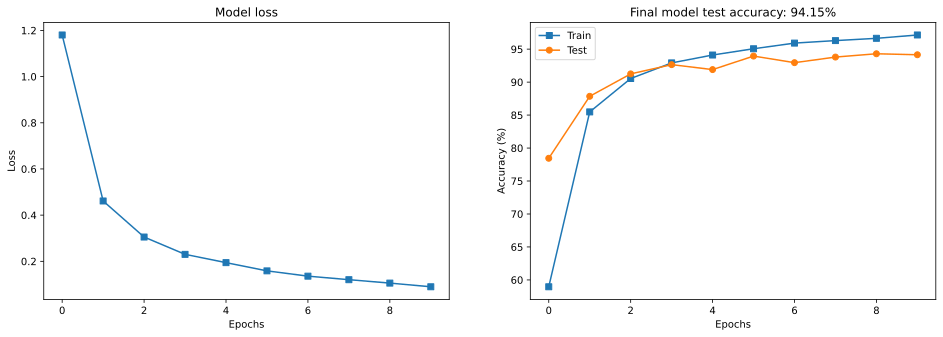

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
expectSize1 = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
expectSize = 20*int(expectSize1**2)

print(expectSize)

500


# Additional explorations

In [ ]:
# 1) Do we need both convolution layers in this model? Comment out the "conv2" layers in the mode definition. What else
#    needs to be changed in the code for this to work with one convolution layer? Once you get it working, how does the
#    accuracy compare between one and two conv layers? (hint: perhaps try adding some more training epochs)
#
#    Your observation here is actually the main reason why MNIST isn't very useful for evaluating developments in DL:
#    MNIST is way too easy! Very simple models do very well, so there is little room for variability. In fact, we'll
#    stop using MNIST pretty soon...
#
#    Final note about MNIST: You probably won't get much higher than 98% with this small dataset. These kinds of CNNs
#    can get >99% test-accuracy with the full dataset (60k samples instead of 18k).
#

(20000, 784)
